# 1. Imports

In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision.transforms import v2
import imageio
from IPython.display import Image, display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import time
import itertools
from io import BytesIO
import pandas as pd

# Show all columns in pandas
pd.set_option('display.max_rows', None)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


# 2. Global Variables and Constants

In [3]:
NUM_FRAMES = 16  # Default number of frames (used in data preprocessing)
FRAME_SIZE = (224, 224)  # Width, height
BATCH_SIZE = 32  # Default batch size
RES_DIR = os.path.join('..', 'res')
CLASSES = ['squat', 'deadlift', 'bench press']
NUM_CLASSES = len(CLASSES)
NUM_EPOCHS = 100
TRAIN_SIZE = 0.7
VALIDATION_SIZE = 0.15
CHECKPOINT_FILEPATH = 'model.keras'
SHOW_VISUALIZATIONS = True  # Avoid visualizations
TEST = False  # Avoid time consuming operations
FIGURES_DIR = os.path.join(RES_DIR, 'figs')  # Folder containing figures created by the script
SEED = 42

In [4]:
os.makedirs(FIGURES_DIR, exist_ok=True)  # Create figures directory if it does not exist

# 3. Helper Functions

In [5]:
def convert_channels(images: np.ndarray, channels_first: bool):  # frames are usually T, W, H, C
    if channels_first and images.shape[-1] == 3:
        return np.transpose(images, (3, 0, 1, 2))  # (T, W, H, C) -> (C, T, W, H)
    elif not channels_first and images.shape[0] == 3:
        return np.transpose(images, (1, 2, 3, 0))  # (C, T, W, H) -> (T, W, H, C)
    return images

In [6]:
def extract_frames(video_path, num_frames=NUM_FRAMES, frame_size=FRAME_SIZE, rescale=True, channels_first=True):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate frame indices to sample
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    frames = []
    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret, frame = cap.read()
        if not ret:
            break

        # Convert to color, resize and normalize frame
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, frame_size)
            
        frames.append(frame)

    cap.release()

    # Padding if necessary
    if len(frames) < num_frames:
        frames.extend([frames[-1]] * (num_frames - len(frames)))

    frames = np.array(frames)

    if frames.ndim != 4:
        frames = np.expand_dims(frames, axis=-1)  # Add channel dimension

    if rescale:
        frames = frames / 255.0

    if channels_first:
        frames = convert_channels(frames, channels_first)

    return frames

In [7]:
def to_gif(images: np.ndarray, filename=None):
    if images.shape[-1] == 1:
        images = images.squeeze(-1)
        
    converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
    
    buffer = BytesIO()
    imageio.mimsave(buffer, converted_images, format='GIF', fps=10, loop=0)
    buffer.seek(0)
    
    if filename:
        with open(os.path.join(FIGURES_DIR, filename), 'wb') as f:
            f.write(buffer.getvalue())
    
    # Display the GIF
    return display(Image(data=buffer.read(), format='png'))

In [8]:
def results_to_dataframe(results):
    # Extract data
    df = pd.DataFrame(
        {
            "num_frames": [int(key.split(":")[-1].strip("} ")) for key in results.keys()],
            "accuracy": [value["accuracy"] for value in results.values()],
            "loss": [value["loss"] for value in results.values()],
            "elapsed_time": [value["elapsed_time"] for value in results.values()]
        }
    )
    
    return df

In [9]:
def add_channel_dim(images: np.ndarray):
    if images.ndim == 4:
        return images
    
    return np.expand_dims(images, axis=-1)

# 4. Data Preparation

## 4.1. Frame Extraction and Preprocessing

In [10]:
def get_paths_and_labels(video_dir, labels):
    video_paths = []
    video_labels = []

    for idx, label in enumerate(labels):
        class_dir = os.path.join(video_dir, label)
        for video in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video)

            video_paths.append(video_path)
            video_labels.append(idx)
    
    return video_paths, video_labels

In [11]:
paths, labels = get_paths_and_labels(RES_DIR, CLASSES)

In [12]:
print(f"Number of videos: {len(paths)}")

Number of videos: 121


## 4.2. Data Splitting

In [13]:
X_temp, X_test, y_temp, y_test = train_test_split(paths, labels, test_size=(1 - TRAIN_SIZE - VALIDATION_SIZE), stratify=labels, random_state=SEED)

In [14]:
sample_idx = np.random.randint(0, len(X_temp) - 1)  # Index as a sample

# 5. Exploratory Data Analysis (EDA)

## 5.1. Frame Visualization

In [15]:
def visualize_frames(video_paths, video_labels, filename=None):    
    video = extract_frames(video_paths[sample_idx], channels_first=False)

    label = CLASSES[video_labels[sample_idx]]
    
    # Select a random frame from the video
    frame_idx = np.random.randint(0, video.shape[0])
    frame = video[frame_idx]
    print(f"Shape of frame: {frame.shape}")
    
    plt.figure(figsize=(5, 5))
    plt.imshow(frame)
    plt.title(f"Label: {label.title()}. Frame: {frame_idx + 1}")
    plt.axis('off')
    
    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, f"{filename}_{sample_idx}.png"), dpi=300)

    plt.show()
    plt.clf()
    plt.close()

Shape of frame: (224, 224, 3)


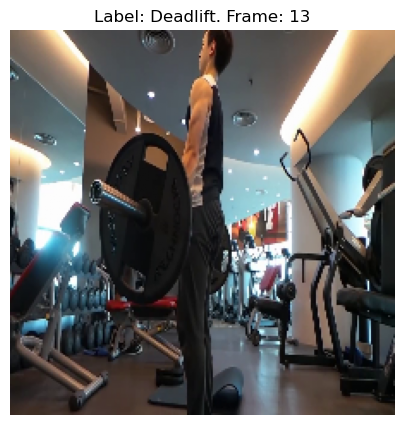

In [16]:
if SHOW_VISUALIZATIONS:
    visualize_frames(X_temp, y_temp, filename="frame_visualization")

## 5.2. Temporal Analysis

In [17]:
def visualize_temporal_sequence(X, y, frames_to_show=None, filename=None):
    # Select random indices    
    video = extract_frames(X[sample_idx], channels_first=False)
    
    label = CLASSES[y[sample_idx]]

    if frames_to_show is None:
        frames_to_show = video.shape[0]  # Should be NUM_FRAMES

    # Calculate number of rows based on frames_to_show and number of columns
    cols = 4
    rows = (frames_to_show + cols - 1) // cols

    # Show frames in grid
    plt.figure(figsize=(cols*3, rows*3))
    for i in range(frames_to_show):
        plt.subplot(rows, cols, i+1)
        plt.imshow(video[i])
        plt.axis('off')
        plt.title(f"Frame {i+1}")
    
    plt.suptitle(f"Video Label: {label}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, f"{filename}_{sample_idx}.png"), dpi=300)

    plt.show()
    plt.clf()
    plt.close()

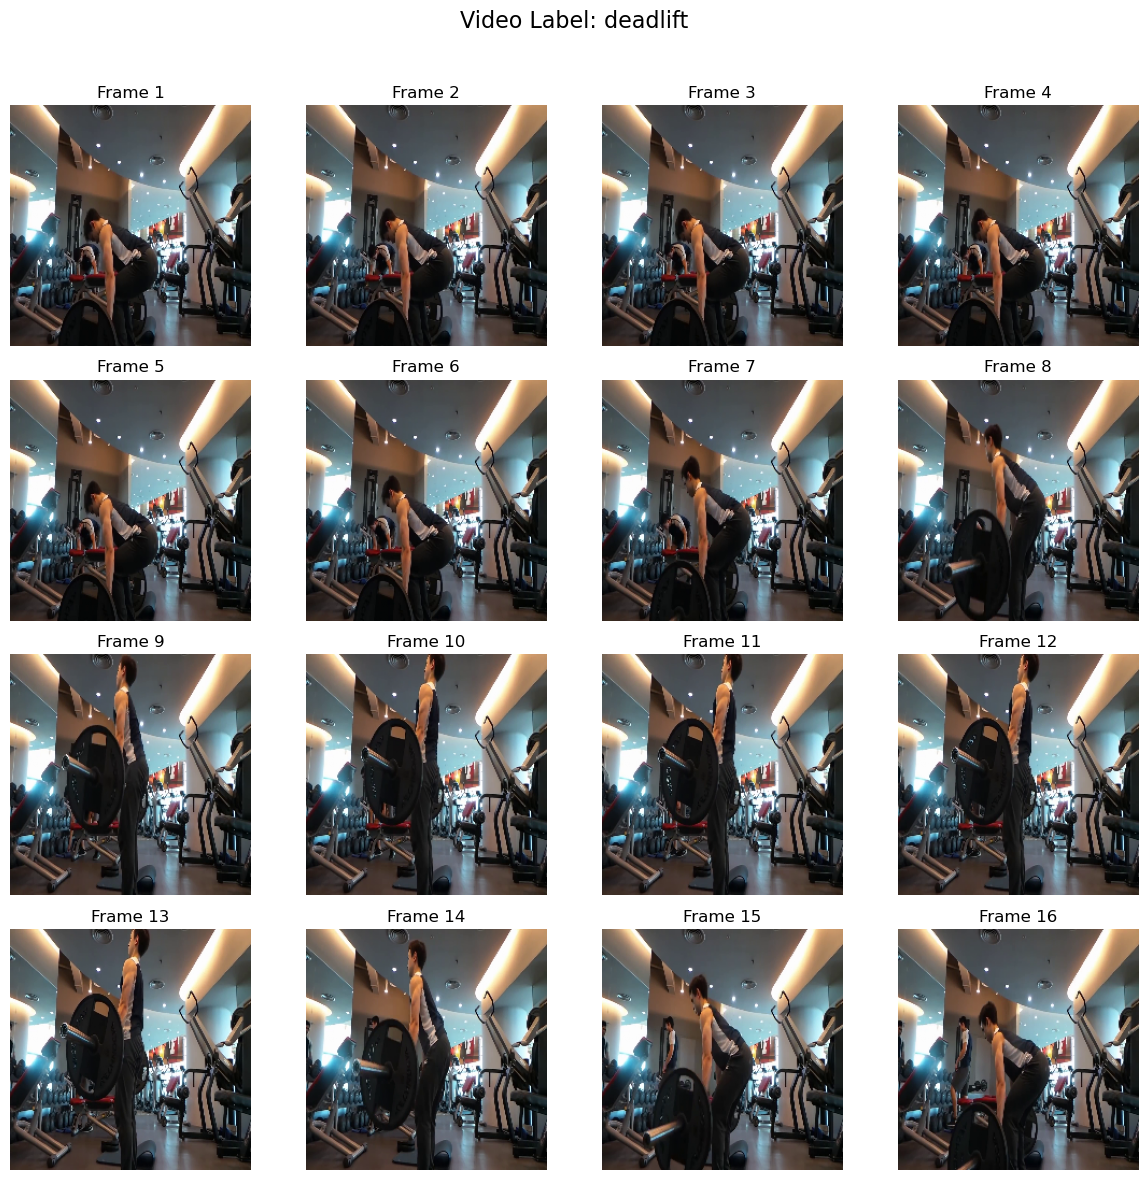

In [18]:
if SHOW_VISUALIZATIONS:
    visualize_temporal_sequence(X_temp, y_temp, filename="temporal_sequence")

## 5.3. Class Distribution

In [19]:
def visualize_class_distribution(y, filename=None):
    # Count the occurrences of each class using numpy
    unique, counts = np.unique(y, return_counts=True)
    
    # Plot
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=unique, y=counts)
    plt.title("Class Distribution")
    
    plt.xticks(ticks=np.arange(len(CLASSES)), labels=CLASSES, rotation=45)
    
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Annotate each bar
    for i, count in enumerate(counts):
        ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=10)

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)

    plt.show()
    plt.clf()
    plt.close()

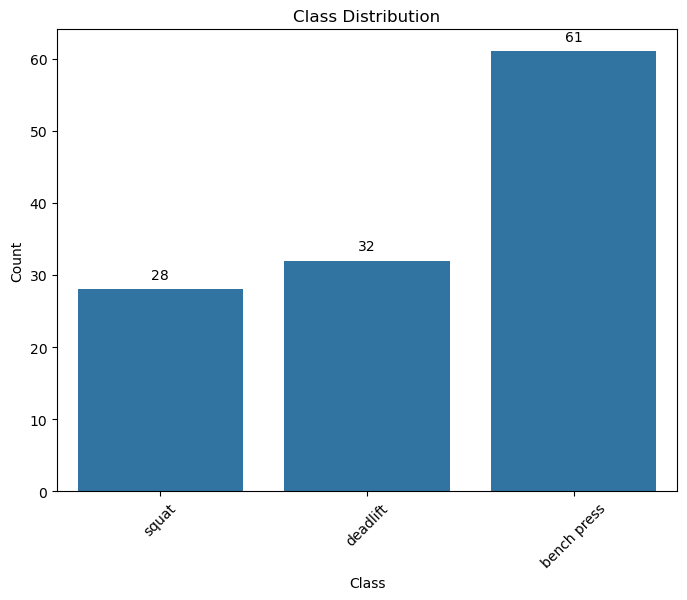

In [20]:
if SHOW_VISUALIZATIONS:
    visualize_class_distribution(labels, filename='class_distribution.png')

# 6. Feature Engineering

## 6.1. Motion Features

### 6.1.1. Frame differencing

In [21]:
def extract_frame_difference(video_path, threshold=30, assign_value=255):
    # https://medium.com/@abbessafa1998/motion-detection-techniques-with-code-on-opencv-18ed2c1acfa
    video = extract_frames(video_path, rescale=False, channels_first=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in video]

    for t in range(1, num_frames):
        # Compute absolute difference between frames (t-1) and t
        diff = cv2.absdiff(gray_frames[t - 1], gray_frames[t])
        
        # Apply threshold to compute motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

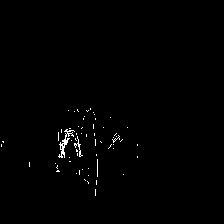

In [22]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_frame_difference(X_temp[sample_idx]), filename=f'frame_difference_{sample_idx}.gif')

### 6.1.2. Background Subtraction

In [23]:
def extract_background_subtraction(video_path, threshold=30, assign_value=255):
    video = extract_frames(video_path, rescale=False, channels_first=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in video]

    # Initialize the background with the first frame
    background = gray_frames[0]

    for t in range(1, num_frames):
        # Compute the absolute difference between the background and current frame
        diff = cv2.absdiff(background, gray_frames[t])

        # Apply thresholding to create a motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        # Normalize motion mask to [0, 1] for consistency
        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

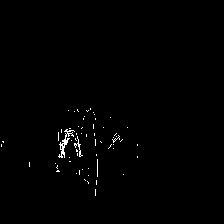

In [24]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_background_subtraction(X_temp[sample_idx]), filename=f'background_subtraction_{sample_idx}.gif')

### 6.1.3. Adaptive Background Substraction

In [25]:
def extract_adaptive_background_subtraction(video_path, threshold=30, assign_value=255, alpha=0.5):
    video = extract_frames(video_path, rescale=False, channels_first=False)

    num_frames = video.shape[0]
    motion_masks = []

    # Convert all frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in video[:num_frames]]

    # Initialize the background with the first frame
    background = gray_frames[0]

    for t in range(1, num_frames):
        # Compute the absolute difference between the background and current frame
        diff = cv2.absdiff(background.astype(np.uint8), gray_frames[t])

        # Apply thresholding to create a motion mask
        _, motion_mask = cv2.threshold(diff, threshold, assign_value, cv2.THRESH_BINARY)

        # Update the background using the adaptive approach
        background = alpha * gray_frames[t] + (1 - alpha) * background

        # Normalize motion mask to [0, 1] for consistency
        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    if len(motion_masks) < NUM_FRAMES:
        motion_masks.extend([motion_masks[-1]] * (NUM_FRAMES - len(motion_masks)))

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

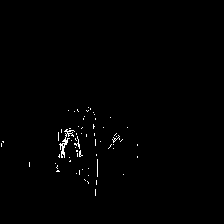

In [26]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_adaptive_background_subtraction(X_temp[sample_idx]), filename=f'adaptive_background_subtraction_{sample_idx}.gif')

### 6.1.4. Mixture of Gaussians (MoG)

In [27]:
def extract_mog(video_path, learning_rate=-1):
    video = extract_frames(video_path, rescale=False, channels_first=False)
    
    num_frames = video.shape[0]
    fgbg = cv2.createBackgroundSubtractorMOG2()
    motion_masks = []

    for t in range(num_frames):
        # Apply MOG to compute motion mask
        motion_mask = fgbg.apply(video[t], learningRate=learning_rate)

        motion_mask = motion_mask / 255.0
        motion_masks.append(motion_mask)

    motion_masks = np.array(motion_masks)
    return add_channel_dim(motion_masks)

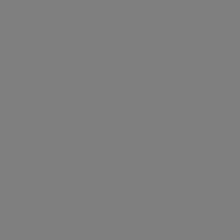

In [28]:
if SHOW_VISUALIZATIONS:
    to_gif(extract_mog(X_temp[sample_idx]), filename=f'mog_{sample_idx}.gif')

## 6.2. Data Augmentation

(16, 224, 224, 3)


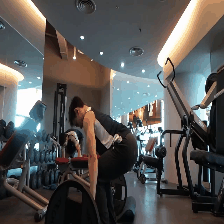

In [29]:
if SHOW_VISUALIZATIONS:
    sample_frames = extract_frames(X_temp[sample_idx], channels_first=False)
    print(sample_frames.shape)
    to_gif(sample_frames, filename=f'original_sample_{sample_idx}.gif')

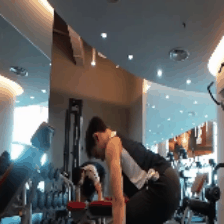

In [30]:
if SHOW_VISUALIZATIONS:
    augmentor = v2.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(1.0, 1.0))

    sample_frames_tensor_channel_first = torch.from_numpy(convert_channels(sample_frames, channels_first=True)).to(device=device)
    augmented_video = augmentor(sample_frames_tensor_channel_first)
    to_gif(convert_channels(augmented_video.detach().cpu().numpy(), channels_first=False), filename=f'augmented_sample_{sample_idx}.gif')

# 7. The Model

## 7.1. Model design

In [31]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # Load pretrained 3D ResNet
        self.weights = models.video.R3D_18_Weights.DEFAULT
        self.base_model = models.video.r3d_18(weights=self.weights)

        # Replace the last fully connected layer
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        # Pass input through the modified base model
        x = self.base_model(x)
        return x

In [32]:
# Define the model creation function
def create_model(num_frames):
    # Create the model
    model = Net(num_frames)

    # Freeze all layers except the last one
    for param in model.base_model.parameters():
        param.requires_grad = False

    model.base_model.fc.weight.requires_grad = True
    model.base_model.fc.bias.requires_grad = True

    return model

## 7.2. Dataset design

In [33]:
class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, paths, targets, func, params):
        self.paths = paths
        self.targets = targets
        
        # Pre-load all frames
        self.frames = [func(path, **params) for path in self.paths]

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        frames = self.frames[idx]
        target = self.targets[idx]
        
        # Move data to the specified device (CUDA or CPU) when accessed
        frames = torch.tensor(frames, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.int64)

        frames = frames.pin_memory().to(device)
        target = target.pin_memory().to(device)

        return frames, target

In [34]:
def create_dataset(paths, targets, func, params):
    return VideoDataset(paths, targets, func, params)

In [35]:
def prepare(dataset, shuffle=False, batch_size=BATCH_SIZE):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle
    )

# 8. Evaluating extraction parameters

In [36]:
def run_model(train_ds, val_ds, params, return_history=False, verbose=True):
    # Start timing
    start_time = time.perf_counter()

    # Initialize the model
    model = create_model(params.get('num_frames', NUM_FRAMES)).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params.get('learning_rate', 0.001))

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-5)

    # Early stopping
    early_stopping_patience = 10

    # Training and validation loop
    history = {"loss": [], "accuracy": [], "val_loss": [], "val_accuracy": []}

    num_epochs = params.get('num_epochs', NUM_EPOCHS)

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for frames, labels in train_ds:
            frames, labels = frames.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(frames)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute training accuracy
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss /= len(train_ds)
        train_accuracy = correct / total
        history["loss"].append(train_loss)
        history["accuracy"].append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for frames, labels in val_ds:
                frames, labels = frames.to(device), labels.to(device)

                outputs = model(frames)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_ds)
        val_accuracy = correct / total
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        scheduler.step(val_loss)

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss.")
            break

        # Logging
        if verbose:
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Calculate elapsed time
    elapsed_time = time.perf_counter() - start_time

    if return_history:
        return model, history

    return history["val_loss"][-1], history["val_accuracy"][-1], elapsed_time


In [37]:
def test_extraction_method_with_params(X_temp, y_temp, func, parameters=None, k=3):
    # Generate all possible parameter combinations using itertools.product
    param_combinations = list(itertools.product(*parameters.values())) if parameters else [()]

    print('------------------------------------------------------------------------')
    print(f"Testing frame extraction method: {func.__name__}. K: {k}")

    # Store results
    results = {}

    # Loop through each parameter combination
    for param_set in param_combinations:
        # Create a dictionary of parameters for the current combination
        param_dict = dict(zip(parameters.keys(), param_set)) if parameters else {}

        print(f"Testing parameters: {param_dict}")

        accuracies = []
        losses = []
        times = []

        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
        fold_no = 1

        # Stratified K-Fold Cross-Validation
        for train_index, val_index in skf.split(X_temp, y_temp):
            # Split paths and labels into training and validation sets
            X_train, X_val = np.array(X_temp)[train_index], np.array(X_temp)[val_index]
            y_train, y_val = np.array(y_temp)[train_index], np.array(y_temp)[val_index]

            train_ds = create_dataset(X_train, y_train, func, param_dict)
            val_ds = create_dataset(X_val, y_val, func, param_dict)

            # Prepare the datasets
            train_ds = prepare(train_ds, shuffle=True)
            val_ds = prepare(val_ds)

            # Run the model with the current parameters
            result = run_model(train_ds, val_ds, param_dict, return_history=False, verbose=False)

            loss, accuracy, time_taken = result

            accuracies.append(accuracy * 100)
            losses.append(loss)
            times.append(time_taken)
            fold_no += 1

        avg_accuracy = np.mean(accuracies)
        avg_loss = np.mean(losses)
        total_time = np.sum(times)

        # Store results
        results[str(param_dict)] = {
            "accuracy": avg_accuracy,
            "loss": avg_loss,
            "elapsed_time": total_time
        }

    return results


## 8.1. Performance with Extract Frames

In [38]:
if TEST:
    k = 3  # Number of folds for cross-validation

    parameters = {
        'num_frames': [2, 4, 8, 16, 32],
    }

    extract_frames_results = test_extraction_method_with_params(
        X_temp=X_temp,
        y_temp=y_temp,
        func=extract_frames,
        parameters=parameters,
        k=k
    )

In [39]:
if TEST and extract_frames_results:
    results_df = results_to_dataframe(extract_frames_results)
    results_df.head()

For all experiment the number of splits is 3 (Tensorflow Implementation)

(No augmentation)

|	|num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	89.215686|	0.372267|	235.787914|
|1|	4|	91.176470|	0.353208|	269.676073|
|2|	8|	90.196079|	0.410411|	450.984143|
|3|	16|	91.176468|	0.372010|	1033.471241|
|4|	32|	90.196077|	0.415564|	1869.285406|

(Only random horizontal flip)

||	num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	89.215684|	0.362144|	297.589557|
|1|	4|	94.117645|	0.238260|	386.174774|
|2|	8|	90.196079|	0.361921|	693.035556|
|3|	16|	89.215686|	0.333939|	1157.514449|
|4|	32|	88.235293|	0.377601|	1985.717385|

(Only random center crop)

||num_frames|	accuracy	|loss	|elapsed_time|
|------|------|------|------|------|
|0|	2|	90.196077|	0.307025|	315.981754|
|1|	4|	87.254902|	0.347564	|417.386800|
|2|	8|	87.254902|	0.436362|	1133.121224|
|3|	16|	89.215686|	0.325290|	1492.774826|
|4|	32|	90.196079|	0.316628|	2629.287430|

(Random center crop and random horizontal flip)

||	num_frames|	accuracy|	loss|	elapsed_time|
|------|------|------|------|------|
|0|	2|	91.176470|	0.307600|	324.237976|
|1|	4|	87.254900|	0.360304|	446.240952|
|2|	8|	90.196077|	0.316336|	706.525661|
|3|	16|	86.274509|	0.389331|	1252.138003|
|4|	32|	88.235293|	0.505120|	2581.715898|

In [40]:
# break

# 9. Model Training

In [41]:
BATCH_SIZE = 32
NUM_FRAMES = 4

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    train_size=TRAIN_SIZE / (TRAIN_SIZE + VALIDATION_SIZE),
    stratify=y_temp,
    random_state=42
)

train_ds = create_dataset(X_train, y_train, func=extract_frames, params={'num_frames': NUM_FRAMES})
val_ds = create_dataset(X_val, y_val, func=extract_frames, params={'num_frames': NUM_FRAMES})
test_ds = create_dataset(X_test, y_test, func=extract_frames, params={'num_frames': NUM_FRAMES})

# Prepare the datasets
train_ds = prepare(train_ds, shuffle=True, batch_size=BATCH_SIZE)
val_ds = prepare(val_ds, batch_size=BATCH_SIZE)
test_ds = prepare(test_ds, batch_size=BATCH_SIZE)

In [43]:
model, history = run_model(train_ds, val_ds, params={'num_frames': NUM_FRAMES}, return_history=True)

Epoch 1/100 - Train Loss: 1.3115, Train Accuracy: 0.3452, Val Loss: 1.1940, Val Accuracy: 0.3889
Epoch 2/100 - Train Loss: 1.1103, Train Accuracy: 0.4762, Val Loss: 1.1829, Val Accuracy: 0.5000
Epoch 3/100 - Train Loss: 1.0610, Train Accuracy: 0.5000, Val Loss: 1.1072, Val Accuracy: 0.5000
Epoch 4/100 - Train Loss: 0.9941, Train Accuracy: 0.5119, Val Loss: 1.0315, Val Accuracy: 0.5000
Epoch 5/100 - Train Loss: 0.9168, Train Accuracy: 0.5357, Val Loss: 0.9870, Val Accuracy: 0.5556
Epoch 6/100 - Train Loss: 0.8885, Train Accuracy: 0.6190, Val Loss: 0.9542, Val Accuracy: 0.6111
Epoch 7/100 - Train Loss: 0.8524, Train Accuracy: 0.6071, Val Loss: 0.9008, Val Accuracy: 0.6111
Epoch 8/100 - Train Loss: 0.8297, Train Accuracy: 0.6190, Val Loss: 0.8553, Val Accuracy: 0.6111
Epoch 9/100 - Train Loss: 0.7930, Train Accuracy: 0.6429, Val Loss: 0.8252, Val Accuracy: 0.6111
Epoch 10/100 - Train Loss: 0.7383, Train Accuracy: 0.6786, Val Loss: 0.7935, Val Accuracy: 0.6667
Epoch 11/100 - Train Loss: 0.

In [44]:
def plot_train_vs_val_metric(history, metric, title, filename=None):
    train_metric = metric
    val_metric = f"val_{metric}"
    
    metric_array_1 = history[train_metric]
    metric_array_2 = history[val_metric]

    plt.plot(metric_array_1, label=f"Training {metric}")
    plt.plot(metric_array_2, label=f"Validation {metric}")

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric.title())

    plt.legend()

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
    plt.show()
    plt.clf()
    plt.close()

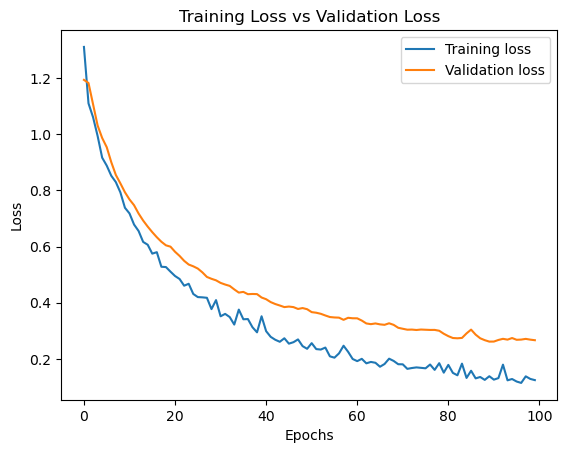

In [45]:
if history:
    plot_train_vs_val_metric(history, 'loss', 'Training Loss vs Validation Loss', filename='training_loss_vs_validation_loss.png')

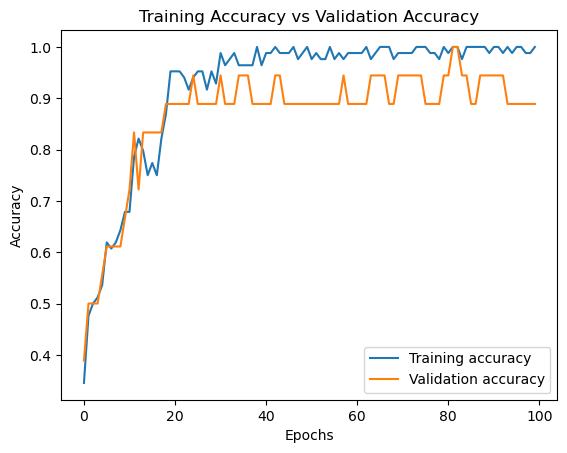

In [46]:
if history:
    plot_train_vs_val_metric(history, 'accuracy', 'Training Accuracy vs Validation Accuracy', filename='training_accuracy_vs_validation_accuracy.png')

In [47]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for frames, labels in val_ds:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames)
        predicted_classes = outputs.argmax(dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted_classes.cpu().numpy())

In [48]:
y_true = np.array(y_true).flatten()
y_pred = np.array(y_pred)

In [49]:
def plot_confusion_matrix(y_true, y_pred, classes, title, filename=None):
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    if filename:
        plt.savefig(os.path.join(FIGURES_DIR, filename), dpi=300)
        
    plt.show()
    plt.clf()
    plt.close()

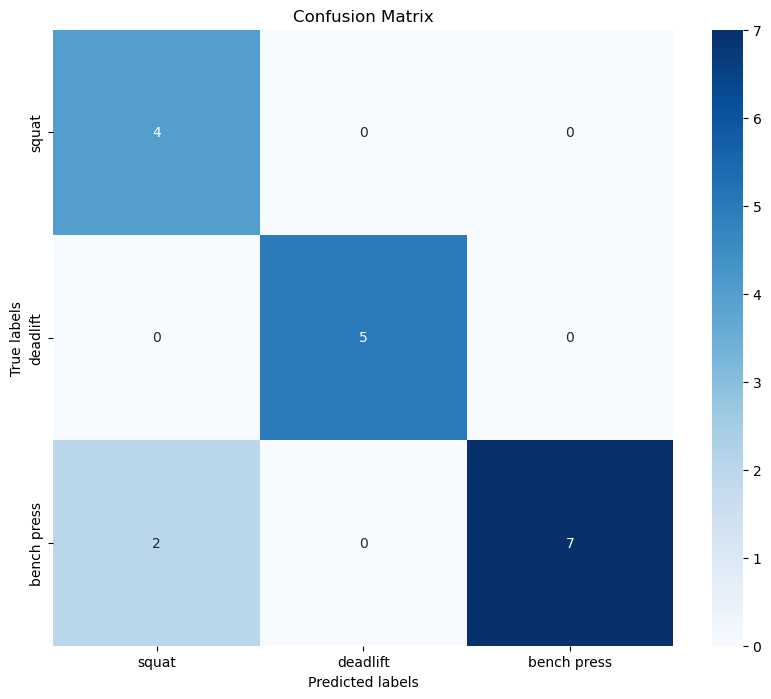

In [50]:
if SHOW_VISUALIZATIONS:
    plot_confusion_matrix(y_true, y_pred, CLASSES, 'Confusion Matrix', filename='confusion_matrix.png')

In [51]:
def display_misclassified_videos(model, dataset):
    num_misclassified = 0
    model.eval()

    with torch.no_grad():
        for batch, (videos, labels) in enumerate(dataset):
            videos, labels = videos.to(device), labels.to(device)

            # Get predictions for the batch
            outputs = model(videos)
            predicted_classes = outputs.argmax(dim=1)
            
            true_classes = labels.cpu().numpy()
            predicted_classes = predicted_classes.cpu().numpy()

            # Identify misclassified samples
            for i in range(len(videos)):
                if predicted_classes[i] != true_classes[i]:
                    print(f"True Class: {CLASSES[true_classes[i]]}, Predicted Class: {CLASSES[predicted_classes[i]]}")
                    
                    frames = videos[i].cpu().numpy()
                    
                    # Generate GIF from video frames
                    print("Displaying incorrectly classified video...")
                    frames = convert_channels(frames, channels_first=False)
                    to_gif(frames)

                    num_misclassified += 1

    if num_misclassified == 0:
        print("No videos were misclassified!")

True Class: bench press, Predicted Class: squat
Displaying incorrectly classified video...


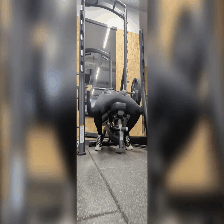

True Class: bench press, Predicted Class: squat
Displaying incorrectly classified video...


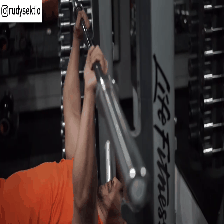

In [52]:
if SHOW_VISUALIZATIONS:
    display_misclassified_videos(model, val_ds)

# 10. Model Testing

In [53]:
print(f"Number of train cases: {len(X_train)}")
print(f"Number of validation cases: {len(X_val)}")
print(f"Number of test cases: {len(X_test)}")

Number of train cases: 84
Number of validation cases: 18
Number of test cases: 19


In [54]:
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for frames, labels in test_ds:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 100.00%
